In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Reshape, LSTM, Bidirectional, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

def print_classes_from_directory(data_dir):
    try:
        # Kiểm tra xem đường dẫn có tồn tại không
        if not os.path.exists(data_dir):
            print(f"Thư mục {data_dir} không tồn tại!")
            return
        
        # Lấy danh sách các thư mục con (lớp) trong thư mục data
        classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
        
        # Sắp xếp và in ra danh sách các lớp
        classes.sort()
        print(f"Tìm thấy {len(classes)} lớp trong thư mục {data_dir}:")
        print(classes)
        
        # In thêm thông tin số lượng ảnh trong mỗi lớp
        print("\nSố lượng ảnh trong mỗi lớp:")
        for class_name in classes:
            class_path = os.path.join(data_dir, class_name)
            # Chỉ đếm các file có đuôi là .png, .jpg hoặc .jpeg
            image_files = [f for f in os.listdir(class_path) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            print(f"{class_name}: {len(image_files)} ảnh")
            
    except Exception as e:
        print(f"Có lỗi xảy ra: {str(e)}")



In [3]:
# Gọi hàm với đường dẫn "../data"
data_dir = "../thu_muc_gop_2"
print_classes_from_directory(data_dir)

Tìm thấy 29 lớp trong thư mục ../thu_muc_gop_2:
['a', 'a1', 'a2', 'b', 'c', 'd', 'd1', 'e', 'e1', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'o1', 'o2', 'p', 'q', 'r', 's', 't', 'u', 'u1', 'v', 'x', 'y']

Số lượng ảnh trong mỗi lớp:
a: 151 ảnh
a1: 191 ảnh
a2: 190 ảnh
b: 204 ảnh
c: 190 ảnh
d: 198 ảnh
d1: 296 ảnh
e: 154 ảnh
e1: 351 ảnh
g: 269 ảnh
h: 462 ảnh
i: 491 ảnh
k: 487 ảnh
l: 369 ảnh
m: 333 ảnh
n: 347 ảnh
o: 212 ảnh
o1: 281 ảnh
o2: 274 ảnh
p: 562 ảnh
q: 372 ảnh
r: 294 ảnh
s: 334 ảnh
t: 413 ảnh
u: 405 ảnh
u1: 388 ảnh
v: 323 ảnh
x: 381 ảnh
y: 390 ảnh


In [4]:
# Tự động phát hiện classes từ thư mục con của ../data1
data_dir = "../thu_muc_gop_2"
try:
    # Chuyển đổi đường dẫn tương đối thành tuyệt đối
    abs_data_dir = os.path.abspath(data_dir)
    print(f"Đường dẫn tuyệt đối đến thư mục dữ liệu: {abs_data_dir}")
    
    # Kiểm tra thư mục dữ liệu có tồn tại không
    if not os.path.exists(abs_data_dir):
        raise ValueError(f"Thư mục {abs_data_dir} không tồn tại!")
    
    # Lấy danh sách các thư mục con (đây sẽ là danh sách classes)
    classes = [d for d in os.listdir(abs_data_dir) if os.path.isdir(os.path.join(abs_data_dir, d))]
    
    # Sắp xếp classes để đảm bảo thứ tự nhất quán
    classes.sort()
    
    NUM_CLASSES = len(classes)
    print(f"Đã phát hiện {NUM_CLASSES} lớp từ thư mục dữ liệu: {classes}")
    
except Exception as e:
    print(f"Lỗi khi phát hiện classes từ thư mục: {str(e)}")
    # Nếu có lỗi, sử dụng danh sách mặc định
    classes = [
        'a', 'ă', 'â', 'b', 'c', 'd', 'đ', 'e', 'ê', 'g',
        'h', 'i', 'k', 'l', 'm', 'n', 'o', 'ô', 'ơ', 'p',
        'q', 'r', 's', 't', 'u', 'ư', 'v', 'x', 'y'
    ]
    NUM_CLASSES = len(classes)
    print(f"Sử dụng danh sách classes mặc định với {NUM_CLASSES} lớp")

Đường dẫn tuyệt đối đến thư mục dữ liệu: c:\kubao\TOAN\VIETNAMESE-CHARACTER-RECOGNITION\DoAn\thu_muc_gop_2
Đã phát hiện 29 lớp từ thư mục dữ liệu: ['a', 'a1', 'a2', 'b', 'c', 'd', 'd1', 'e', 'e1', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'o1', 'o2', 'p', 'q', 'r', 's', 't', 'u', 'u1', 'v', 'x', 'y']


In [5]:
IMG_WIDTH = 50
IMG_HEIGHT = 150
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 1)
# classes = [
#     'a', 'ă', 'â', 'b', 'c', 'd', 'đ', 'e', 'ê', 'g',
#     'h', 'i', 'k', 'l', 'm', 'n', 'o', 'ô', 'ơ', 'p',
#     'q', 'r', 's', 't', 'u', 'ư', 'v', 'x', 'y'
# ]
NUM_CLASSES = len(classes)
data_dir = "../thu_muc_gop_2"
BATCH_SIZE = 32
EPOCHS = 10
PATIENCE = 10
VALIDATION_SPLIT = 0.2

In [6]:
def preprocess_image(image_path, output_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Không thể đọc ảnh từ {image_path}")
    img_resized = cv2.resize(img, output_size, interpolation=cv2.INTER_AREA)
    img_normalized = img_resized / 255.0
    return img_normalized

def load_dataset(data_dir, classes, output_size=(IMG_WIDTH, IMG_HEIGHT)):
    X, y = [], []
    print("Đang tải dữ liệu...")
    
    for idx, label in enumerate(classes):
        class_dir = os.path.join(data_dir, label)
        print(f"Đang tải lớp {label} ({idx+1}/{len(classes)})")
        
        if not os.path.exists(class_dir):
            print(f"Thư mục {class_dir} không tồn tại, bỏ qua.")
            continue
            
        for img_name in os.listdir(class_dir):
            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
                
            img_path = os.path.join(class_dir, img_name)
            try:
                img_normalized = preprocess_image(img_path, output_size)
                X.append(img_normalized)
                y.append(idx)
            except Exception as e:
                print(f"Lỗi khi xử lý ảnh {img_path}: {e}")
    
    return np.array(X), np.array(y)

def prepare_data():
    # Chuyển đổi đường dẫn tương đối sang tuyệt đối để tránh vấn đề với ký tự đặc biệt
    abs_data_dir = os.path.abspath(data_dir)
    print(f"Đường dẫn tuyệt đối đến thư mục dữ liệu: {abs_data_dir}")
    
    # Kiểm tra xem thư mục dữ liệu có tồn tại không
    if not os.path.exists(abs_data_dir):
        raise ValueError(f"Thư mục dữ liệu {abs_data_dir} không tồn tại!")
    
    # Kiểm tra các thư mục lớp có tồn tại không
    existing_classes = []
    for label in classes:
        class_dir = os.path.join(abs_data_dir, label)
        if os.path.exists(class_dir) and os.path.isdir(class_dir):
            existing_classes.append(label)
        else:
            print(f"Thư mục lớp {class_dir} không tồn tại, sẽ bỏ qua lớp này.")
    
    if not existing_classes:
        raise ValueError(f"Không tìm thấy thư mục lớp nào trong {abs_data_dir}!")
    
    print(f"Tìm thấy {len(existing_classes)}/{len(classes)} lớp: {existing_classes}")
    
    try:
        X, y = load_dataset(abs_data_dir, existing_classes)
        
        if len(X) == 0:
            raise ValueError("Không tìm thấy ảnh nào trong các thư mục!")
            
        print(f"Đã tải {len(X)} ảnh, kích thước ảnh: {X[0].shape}")
        print(f"Phân bố nhãn: {np.bincount(y)}")
        
        # Số lượng lớp thực tế dựa trên dữ liệu đã tải
        actual_classes = len(np.unique(y))
        print(f"Số lượng lớp thực tế: {actual_classes}")
        
        y_onehot = to_categorical(y, NUM_CLASSES)
        
        X_train, X_test, y_train, y_test, y_train_onehot, y_test_onehot = train_test_split(
            X, y, y_onehot, test_size=0.2, random_state=42, stratify=y
        )
        
        X_train = X_train.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)
        X_test = X_test.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)
        
        print(f"Kích thước X_train: {X_train.shape}, X_test: {X_test.shape}")
        return X_train, X_test, y_train, y_test, y_train_onehot, y_test_onehot
        
    except Exception as e:
        print(f"Lỗi khi chuẩn bị dữ liệu: {str(e)}")
        print("Thử phương pháp thay thế...")
        
        # Phương pháp thay thế - tìm tất cả các thư mục con
        try:
            subfolders = [f.name for f in os.scandir(abs_data_dir) if f.is_dir()]
            print(f"Đã tìm thấy các thư mục con: {subfolders}")
            
            # Tạo ánh xạ từ tên thư mục đến chỉ số lớp
            class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
            
            # Tải dữ liệu chỉ từ các thư mục tồn tại trong danh sách classes
            existing_folders = [f for f in subfolders if f in class_to_idx]
            if not existing_folders:
                raise ValueError(f"Không có thư mục nào phù hợp với danh sách classes!")
                
            print(f"Tải dữ liệu từ các thư mục: {existing_folders}")
            
            X_alt, y_alt = [], []
            for folder in existing_folders:
                folder_path = os.path.join(abs_data_dir, folder)
                class_idx = class_to_idx[folder]
                
                image_files = [f for f in os.listdir(folder_path) 
                             if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                
                for img_file in image_files:
                    img_path = os.path.join(folder_path, img_file)
                    try:
                        img = preprocess_image(img_path)
                        X_alt.append(img)
                        y_alt.append(class_idx)
                    except Exception as img_error:
                        print(f"Bỏ qua ảnh {img_path}: {str(img_error)}")
            
            if not X_alt:
                raise ValueError("Không thể tải bất kỳ ảnh nào!")
                
            X_alt = np.array(X_alt)
            y_alt = np.array(y_alt)
            
            print(f"Đã tải {len(X_alt)} ảnh bằng phương pháp thay thế")
            print(f"Phân bố nhãn: {np.bincount(y_alt)}")
            
            y_alt_onehot = to_categorical(y_alt, NUM_CLASSES)
            
            X_train, X_test, y_train, y_test, y_train_onehot, y_test_onehot = train_test_split(
                X_alt, y_alt, y_alt_onehot, test_size=0.2, random_state=42, stratify=y_alt
            )
            
            X_train = X_train.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)
            X_test = X_test.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)
            
            print(f"Kích thước X_train: {X_train.shape}, X_test: {X_test.shape}")
            return X_train, X_test, y_train, y_test, y_train_onehot, y_test_onehot
            
        except Exception as alt_error:
            raise ValueError(f"Không thể tải dữ liệu bằng phương pháp thay thế: {str(alt_error)}")

In [7]:
def create_cnn_model():
    # Sử dụng Functional API thay vì Sequential để tránh cảnh báo
    inputs = Input(shape=INPUT_SHAPE)
    
    # Lớp tích chập và pooling thứ nhất
    x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Lớp tích chập và pooling thứ hai
    x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Lớp tích chập và pooling thứ ba
    x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Dropout để tránh overfitting
    x = Dropout(0.25)(x)
    
    # Flatten và fully connected layers
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # Lớp output
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    
    # Tạo mô hình
    model = Model(inputs=inputs, outputs=outputs)
    
    # Biên dịch mô hình
    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    
    model.summary()
    return model


def create_cnn_lstm_model():
    inputs = Input(shape=INPUT_SHAPE)
    
    # Phần CNN
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Lấy kích thước thực tế sau khi đi qua các lớp conv và pooling
    conv_shape = tf.keras.backend.int_shape(x)
    new_height = conv_shape[1]  # Lấy kích thước thực tế thay vì tính toán
    new_width = conv_shape[2]
    filters = conv_shape[3]
    
    # Reshape với kích thước đúng
    x = Reshape((new_height, new_width * filters))(x)
    
    # Phần LSTM
    x = Bidirectional(LSTM(128, return_sequences=False))(x)
    x = Dropout(0.25)(x)
    
    # Fully connected layers
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # Lớp output
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    
    # Tạo mô hình
    model = Model(inputs=inputs, outputs=outputs)
    
    # Biên dịch mô hình
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    model.summary()
    return model

In [8]:
def train_model(model, X_train, y_train, X_val, y_val, model_name, epochs=EPOCHS):
    os.makedirs('models1', exist_ok=True)
    checkpoint = ModelCheckpoint(f'models1/new_best_{model_name}.keras', 
                                 monitor='val_accuracy', 
                                 save_best_only=True, 
                                 verbose=1)
    early_stopping = EarlyStopping(monitor='val_accuracy', 
                                   patience=PATIENCE, 
                                   verbose=1,
                                   restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.2, 
                                  patience=5, 
                                  min_lr=0.0001, 
                                  verbose=1)
    history = model.fit(X_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=epochs,
                        validation_data=(X_val, y_val),
                        callbacks=[checkpoint, early_stopping, reduce_lr])
    return history

In [9]:
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} - Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} - Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.savefig(f'{model_name}_training_history.png')
    plt.show()

def evaluate_model(model, X_test, y_test, y_test_onehot, classes, model_name):
    score = model.evaluate(X_test, y_test_onehot, verbose=0)
    print(f"{model_name} - Loss: {score[0]}, Accuracy: {score[1]}")
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes, target_names=classes))
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.title(f'Ma trận nhầm lẫn - {model_name}')
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.show()
    return y_pred_classes

In [10]:
X_train, X_test, y_train, y_test, y_train_onehot, y_test_onehot = prepare_data()

Đường dẫn tuyệt đối đến thư mục dữ liệu: c:\kubao\TOAN\VIETNAMESE-CHARACTER-RECOGNITION\DoAn\thu_muc_gop_2
Tìm thấy 29/29 lớp: ['a', 'a1', 'a2', 'b', 'c', 'd', 'd1', 'e', 'e1', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'o1', 'o2', 'p', 'q', 'r', 's', 't', 'u', 'u1', 'v', 'x', 'y']
Đang tải dữ liệu...
Đang tải lớp a (1/29)


Đang tải lớp a1 (2/29)
Đang tải lớp a2 (3/29)
Đang tải lớp b (4/29)
Đang tải lớp c (5/29)
Đang tải lớp d (6/29)
Đang tải lớp d1 (7/29)
Đang tải lớp e (8/29)
Đang tải lớp e1 (9/29)
Đang tải lớp g (10/29)
Đang tải lớp h (11/29)
Đang tải lớp i (12/29)
Đang tải lớp k (13/29)
Đang tải lớp l (14/29)
Đang tải lớp m (15/29)
Đang tải lớp n (16/29)
Đang tải lớp o (17/29)
Đang tải lớp o1 (18/29)
Đang tải lớp o2 (19/29)
Đang tải lớp p (20/29)
Đang tải lớp q (21/29)
Đang tải lớp r (22/29)
Đang tải lớp s (23/29)
Đang tải lớp t (24/29)
Đang tải lớp u (25/29)
Đang tải lớp u1 (26/29)
Đang tải lớp v (27/29)
Đang tải lớp x (28/29)
Đang tải lớp y (29/29)
Đã tải 9312 ảnh, kích thước ảnh: (150, 50)
Phân bố nhãn: [151 191 190 204 190 198 296 154 351 269 462 491 487 369 333 347 212 281
 274 562 372 294 334 413 405 388 323 381 390]
Số lượng lớp thực tế: 29
Kích thước X_train: (7449, 150, 50, 1), X_test: (1863, 150, 50, 1)


In [11]:
cnn_model = create_cnn_model()
cnn_history = train_model(cnn_model, X_train, y_train_onehot, X_test, y_test_onehot, "cnn")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 50, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 50, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 6, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18, 6, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 13824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,539,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         7,453 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,639,325 (13.88 MB)

 Trainable params: 3,639,325 (13.88 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.2114 - loss: 2.8492
Epoch 1: val_accuracy improved from -inf to 0.74289, saving model to models1/new_best_cnn.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 28s 110ms/step - accuracy: 0.2121 - loss: 2.8465 - val_accuracy: 0.7429 - val_loss: 0.9343 - learning_rate: 0.0010
Epoch 2/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6733 - loss: 1.0623
Epoch 2: val_accuracy improved from 0.74289 to 0.86366, saving model to models1/new_best_cnn.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 26s 110ms/step - accuracy: 0.6734 - loss: 1.0619 - val_accuracy: 0.8637 - val_loss: 0.5098 - learning_rate: 0.0010
Epoch 3/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7998 - loss: 0.6692
Epoch 3: val_accuracy improved from 0.86366 to 0.90499, saving model to models1/new_best_cnn.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 26s 112ms/step - accuracy: 0.7999 - loss: 0.6691 - val_accuracy: 0.9050 - val_loss: 0.3496 - learning_rate: 0.0010
Epoch 4/10

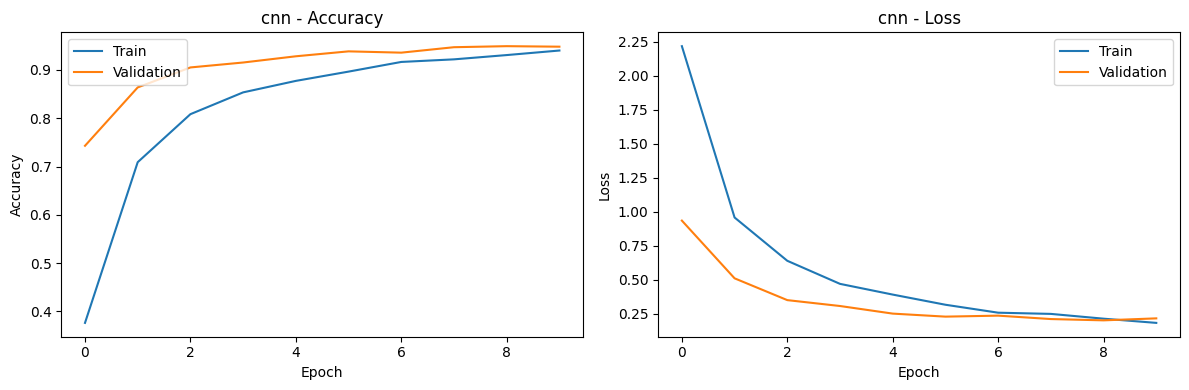

cnn - Loss: 0.2008555382490158, Accuracy: 0.949006974697113
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step

Classification Report:
              precision    recall  f1-score   support

           a       0.94      1.00      0.97        30
          a1       0.94      0.89      0.92        38
          a2       0.94      0.87      0.90        38
           b       0.95      0.90      0.93        41
           c       0.90      0.92      0.91        38
           d       0.86      0.95      0.90        40
          d1       0.97      0.95      0.96        59
           e       0.96      0.84      0.90        31
          e1       0.94      0.94      0.94        70
           g       1.00      0.96      0.98        54
           h       0.89      0.99      0.94        92
           i       0.93      0.99      0.96        98
           k       0.99      0.89      0.93        97
           l       0.88      0.95      0.91        74
           m       0.98      0.97      0.98        67
           

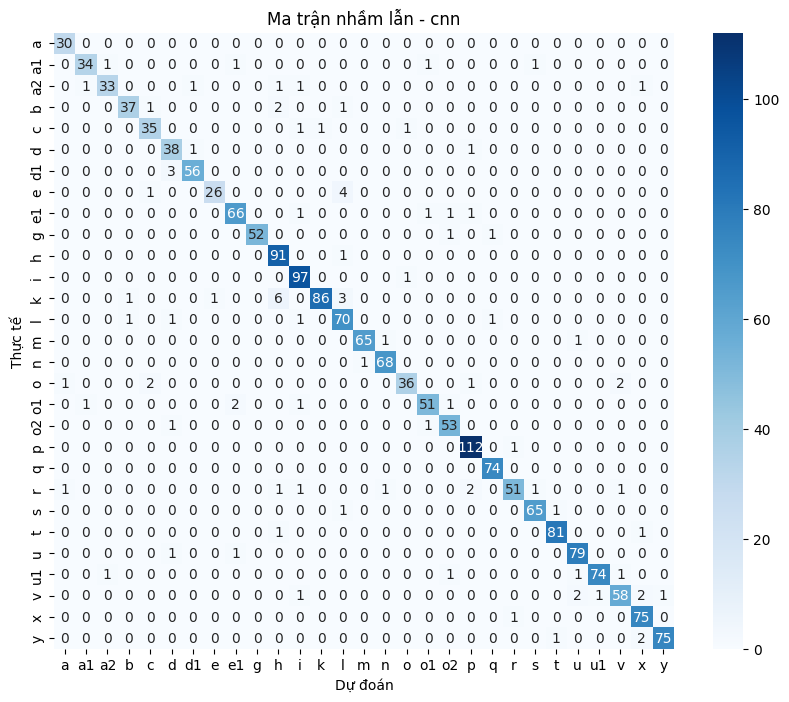

In [12]:
plot_training_history(cnn_history, "cnn")
cnn_predictions = evaluate_model(cnn_model, X_test, y_test, y_test_onehot, classes, "cnn")

In [13]:
cnn_lstm_model = create_cnn_lstm_model()
cnn_lstm_history = train_model(cnn_lstm_model, X_train, y_train_onehot, X_test, y_test_onehot, "cnn_lstm")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 50, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 148, 48, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 36, 704)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       852,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 908,445 (3.47 MB)

 Trainable params: 908,445 (3.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.0653 - loss: 3.2876
Epoch 1: val_accuracy improved from -inf to 0.35963, saving model to models1/new_best_cnn_lstm.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 34s 113ms/step - accuracy: 0.0656 - loss: 3.2866 - val_accuracy: 0.3596 - val_loss: 2.0916 - learning_rate: 0.0010
Epoch 2/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.3812 - loss: 2.0075
Epoch 2: val_accuracy improved from 0.35963 to 0.67203, saving model to models1/new_best_cnn_lstm.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 29s 124ms/step - accuracy: 0.3815 - loss: 2.0062 - val_accuracy: 0.6720 - val_loss: 1.0137 - learning_rate: 0.0010
Epoch 3/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.6433 - loss: 1.1511
Epoch 3: val_accuracy improved from 0.67203 to 0.79656, saving model to models1/new_best_cnn_lstm.keras
233/233 ━━━━━━━━━━━━━━━━━━━━ 33s 140ms/step - accuracy: 0.6434 - loss: 1.1507 - val_accuracy: 0.7966 - val_loss: 0.6755 - learning_rate: 0.

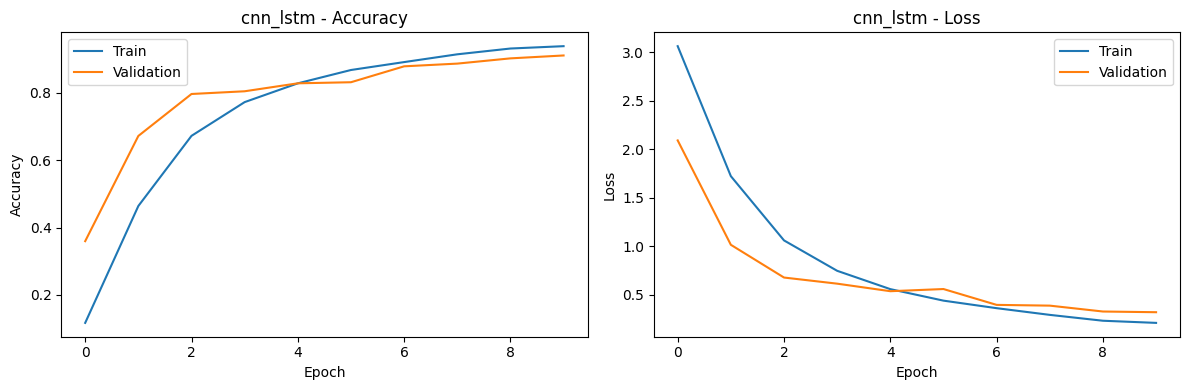

cnn_lstm - Loss: 0.3174889087677002, Accuracy: 0.9108964204788208
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step

Classification Report:
              precision    recall  f1-score   support

           a       0.93      0.93      0.93        30
          a1       0.79      0.82      0.81        38
          a2       0.79      0.87      0.82        38
           b       0.75      0.93      0.83        41
           c       0.92      0.87      0.89        38
           d       0.94      0.80      0.86        40
          d1       0.94      0.98      0.96        59
           e       0.92      0.77      0.84        31
          e1       0.97      0.90      0.93        70
           g       0.90      0.87      0.89        54
           h       0.92      0.87      0.89        92
           i       0.92      0.99      0.96        98
           k       0.85      0.89      0.87        97
           l       0.88      0.85      0.86        74
           m       1.00      0.90      0.94        67
     

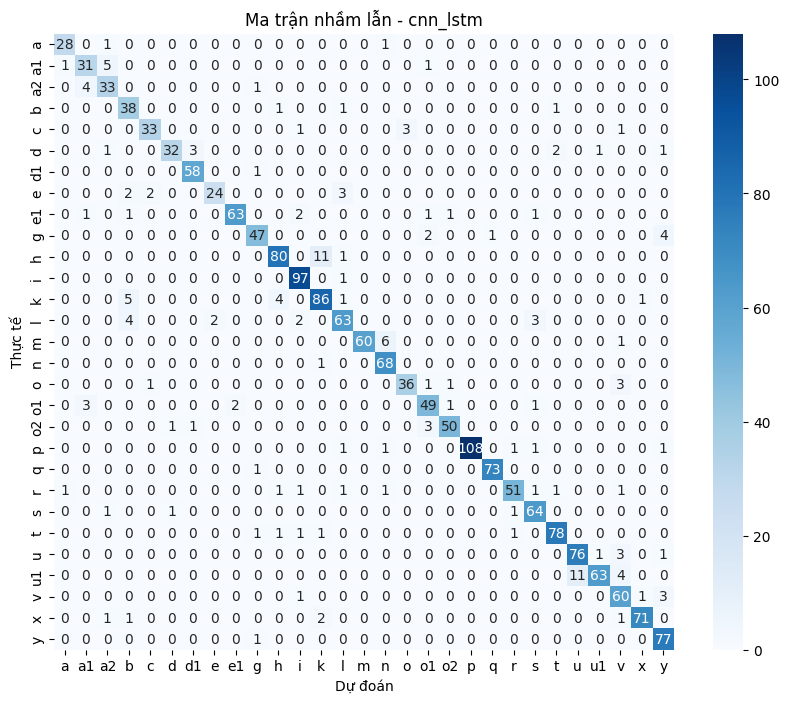

In [14]:
plot_training_history(cnn_lstm_history, "cnn_lstm")
cnn_lstm_predictions = evaluate_model(cnn_lstm_model, X_test, y_test, y_test_onehot, classes, "cnn_lstm")

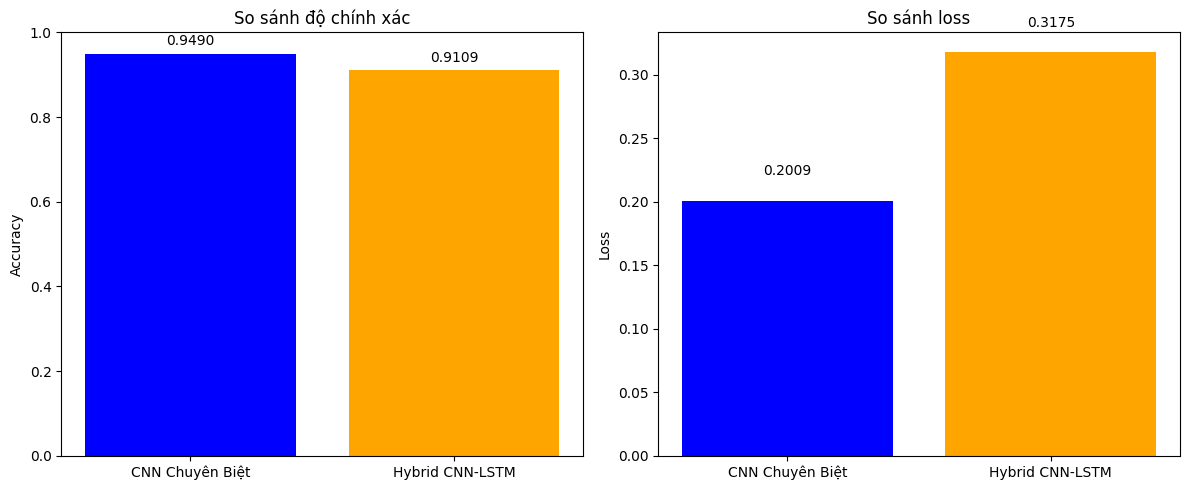

In [15]:
cnn_score = cnn_model.evaluate(X_test, y_test_onehot, verbose=0)
cnn_lstm_score = cnn_lstm_model.evaluate(X_test, y_test_onehot, verbose=0)

model_names = ['CNN Chuyên Biệt', 'Hybrid CNN-LSTM']
accuracies = [cnn_score[1], cnn_lstm_score[1]]
losses = [cnn_score[0], cnn_lstm_score[0]]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(model_names, accuracies, color=['blue', 'orange'])
plt.title('So sánh độ chính xác')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v+0.02, f'{v:.4f}', ha='center')

plt.subplot(1, 2, 2)
plt.bar(model_names, losses, color=['blue', 'orange'])
plt.title('So sánh loss')
plt.ylabel('Loss')
for i, v in enumerate(losses):
    plt.text(i, v+0.02, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.savefig('models_comparison.png')
plt.show()

In [16]:
cnn_model.save('models1/cnn_final.keras')
cnn_lstm_model.save('models1/cnn_lstm_final.keras')
print("Đã lưu cả hai mô hình.")

Đã lưu cả hai mô hình.
